## Evaluation and Calibration Plots

Here we import the previously obtained test set samples from the BNN and SBI models.

In [3]:
#! apt-get update
#!sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super
#!pip install chainconsumer

In [4]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd


# Colab in order to download files
from google.colab import files

# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chainconsumer
from chainconsumer import ChainConsumer

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

### Import data

In [5]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define the data path
DATA_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Datasets/'

# IMAGE PATH
IMG_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Plots/'

# MODEL WEIGHTS PATH
MDL_WEIGHTS_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Saved_Models/'

In [7]:
# Load labels
y_cosmo = np.float64(np.load(DATA_PATH+"cosmo_params_all_collage_flask_6cosmo_n625_jr0_wSN0_jz3.npz.npy"))[:100000]

In [11]:
samples_NPE = np.load(MDL_WEIGHTS_PATH+'samples_test_SBI.npy')
samples_BNN = np.load(MDL_WEIGHTS_PATH+'samples_test_BNN.npy')

In [8]:
# Get omega and sigma 8
y_Omega = y_cosmo[:,0];y_sigma_8 = y_cosmo[:,3]

# Labels for two cosmological parameters 
y_cosmo_2 = np.stack([y_Omega,y_sigma_8],axis=-1)

# Split into training, validation, test sets
y_train  = y_cosmo_2[:80000]
y_val = y_cosmo_2[80000:90000]
y_test = y_cosmo_2[90000:]

In [9]:
y_keep = y_test[:1000]

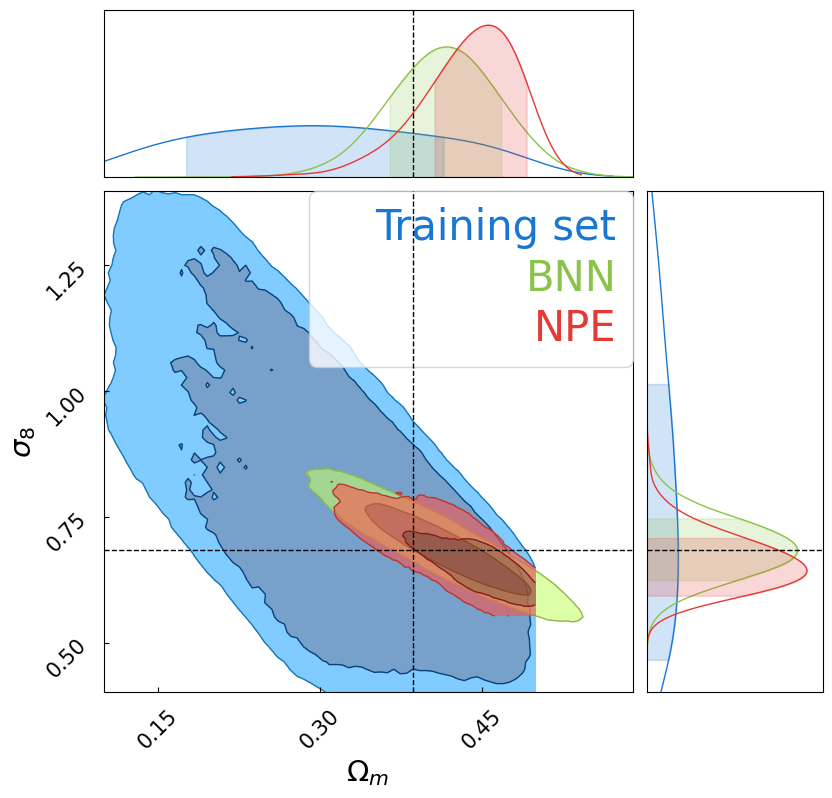

In [30]:
j = 100
params = ["$\Omega_m$", "$\sigma_8$"]


c = ChainConsumer()
c.add_chain(y_train[:5000],parameters=params,name='Training set')
c.add_chain(samples_BNN[j],parameters=params,name='BNN')
c.add_chain(samples_NPE[j],parameters=params,name='NPE')

# Configure plot
c.configure(label_font_size=21,max_ticks=4,tick_font_size=15,
            legend_kwargs={"frameon":True, "fontsize":30}, kde=True)

fig = c.plotter.plot(figsize=(8.4,8.05), truth=y_test[j])

plt.tight_layout()

plt.savefig(IMG_PATH+"Example_Predictions_1.pdf")
plt.show()

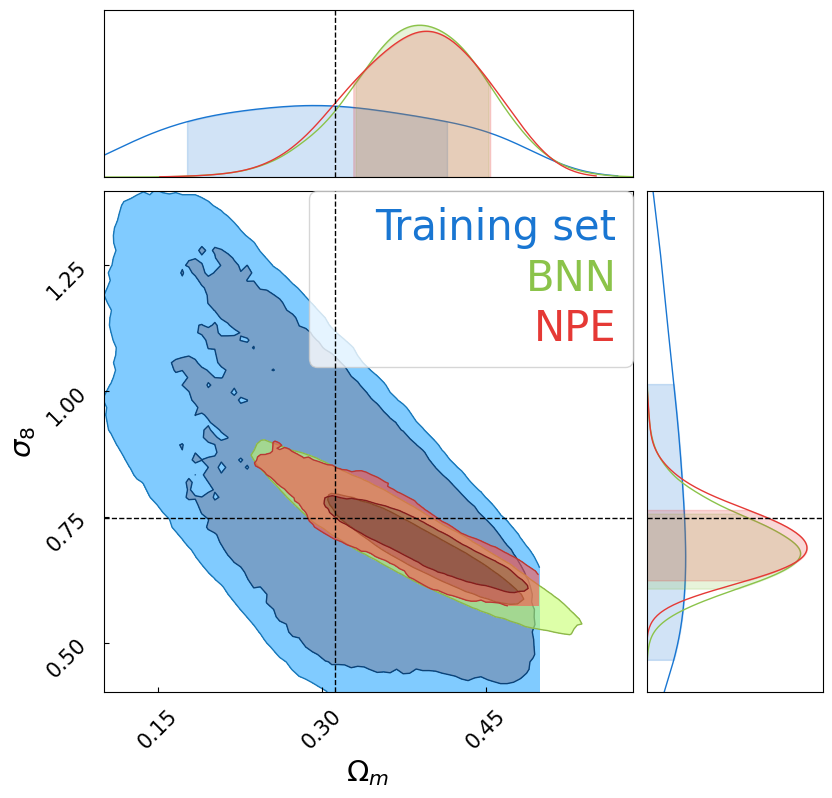

In [29]:
j = 300
params = ["$\Omega_m$", "$\sigma_8$"]


c = ChainConsumer()
c.add_chain(y_train[:5000],parameters=params,name='Training set')
c.add_chain(samples_BNN[j],parameters=params,name='BNN')
c.add_chain(samples_NPE[j],parameters=params,name='NPE')

# Configure plot
c.configure(label_font_size=21,max_ticks=4,tick_font_size=15,
            legend_kwargs={"frameon":True, "fontsize":30}, kde=True)

fig = c.plotter.plot(figsize=(8.4,8.05), truth=y_test[j])

plt.tight_layout()

plt.savefig(IMG_PATH+"Example_Predictions_2.pdf")
plt.show()

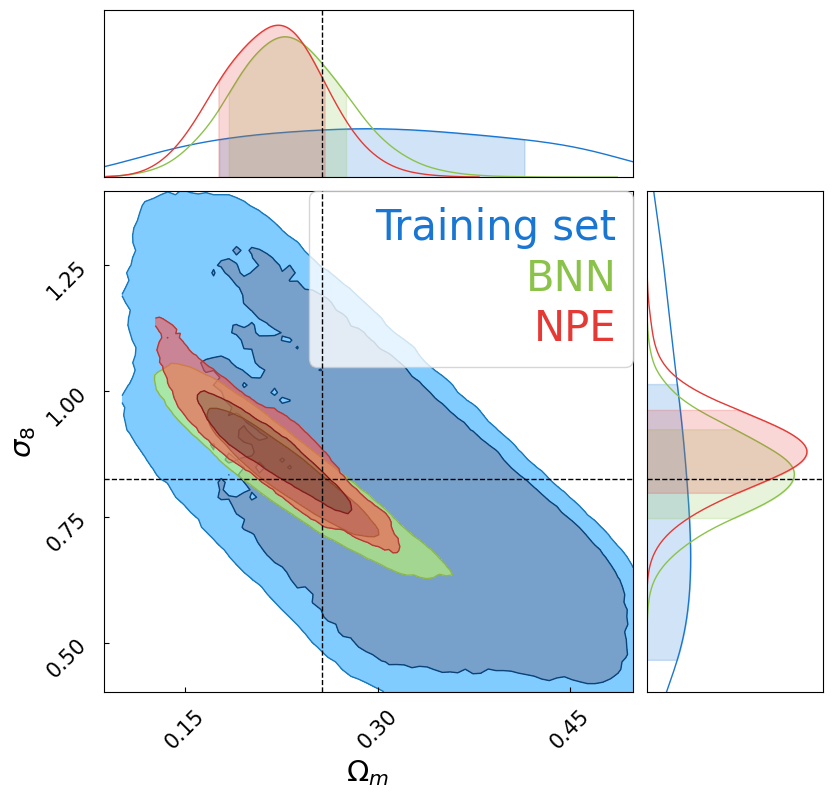

In [28]:
j = 400
params = ["$\Omega_m$", "$\sigma_8$"]


c = ChainConsumer()
c.add_chain(y_train[:5000],parameters=params,name='Training set')
c.add_chain(samples_BNN[j],parameters=params,name='BNN')
c.add_chain(samples_NPE[j],parameters=params,name='NPE')

# Configure plot
c.configure(label_font_size=21,max_ticks=4,tick_font_size=15,
            legend_kwargs={"frameon":True, "fontsize":30}, kde=True)

fig = c.plotter.plot(figsize=(8.4,8.05), truth=y_test[j])

plt.tight_layout()
plt.savefig(IMG_PATH+"Example_Predictions_3.pdf")
plt.show()

### Calibration Plots

Now produce calibration plots


- First define the Mahalanobis distance

In [31]:
def mahalanobis_dist(param_vector, mean_vector, covariance):
  """
  Param vector: [n_samples, n_params]
  """
  # Get number of samples and number of parameters
  n_samples, n_params = np.shape(param_vector)

  # Get inverse covariance
  inv_cov = np.linalg.inv(covariance)

  # Initialize vector of distances
  dist_vect = np.zeros(n_samples)
  # Populate
  for i in range(n_samples):
    diff_i = np.array(param_vector[i] - mean_vector)
    dist_vect[i] = np.sqrt(np.dot(diff_i.T,np.dot(inv_cov,diff_i)))

  return dist_vect 

In [32]:
def prob_coverage(sample, true_params, percentile_list):
  """

  """
  # Get the number of instances, samples, and parameters
  n_inst, n_sample, n_params = np.shape(sample)

  
  #Initialize 
  prob_vol = np.zeros(n_inst)
  for i in range(n_inst):
    # Get array of samples of the i-th instance
    sample_i = sample[i,:,:]
    # Get mean vector and covariance matrix 
    mean = np.mean(sample_i,axis=0)
    cov = np.cov(sample_i,rowvar=False)

    # Get true parameters of the i-th instance
    true_params_i = true_params[i].reshape(1,len(true_params[i]))

    # Get Mahalanobis distances of the samples and the true value
    d_sample_i = mahalanobis_dist(sample_i,mean,cov)
    d_true_i = mahalanobis_dist(true_params_i,mean,cov)

    diff = d_sample_i - d_true_i
    prob_vol[i] = sum(diff<0)/n_sample
  # ==========================================
  # ==========================================
  
  n_perc = len(percentile_list)
  prob_cov = np.zeros(n_perc)

  for i in range(n_perc):
    prob_cov[i] = sum(prob_vol-percentile_list[i]<0)/n_inst

  return prob_cov

In [33]:
percentiles = np.linspace(0,1,50)
prob_covs_NPE = prob_coverage(samples_NPE,y_keep,percentiles)
prob_covs_BNN = prob_coverage(samples_BNN,y_keep,percentiles)

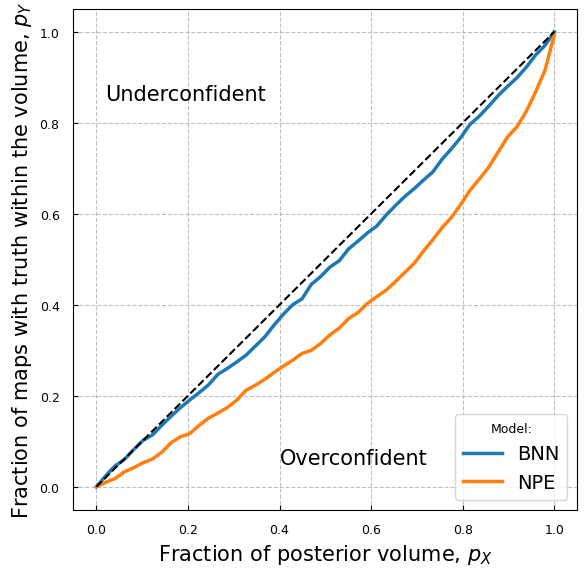

In [47]:
x = np.linspace(0,1,100)
plt.figure(figsize=(6.5, 6.5))


plt.plot(percentiles,prob_covs_BNN,linewidth=2.5,label='BNN')
plt.plot(percentiles,prob_covs_NPE,linewidth=2.5,label='NPE')
plt.grid(ls='--',alpha=0.8)

#plt.plot(percentiles,coverage_Omega)
#plt.plot(percentiles,coverage_sigma)
plt.plot(x,x,ls='--',c='k')

plt.text(0.4,0.05,'Overconfident', fontsize=15)
plt.text(0.02,0.85,'Underconfident',fontsize=15)


plt.xlabel('Fraction of posterior volume, $p_X$',fontsize=15)
plt.ylabel('Fraction of maps with truth within the volume, $p_Y$',fontsize=15)

plt.legend(title='Model:',loc='lower right',fontsize=14)
plt.savefig(IMG_PATH+"Calibration_Plot_Comparison.pdf")
plt.show()